*****(A)*****

In [31]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm  # For progress bars

# Device configuration
device = torch.device('cpu')
print(f"Using device: {device}")


Using device: cpu


Files already downloaded and verified
Files already downloaded and verified


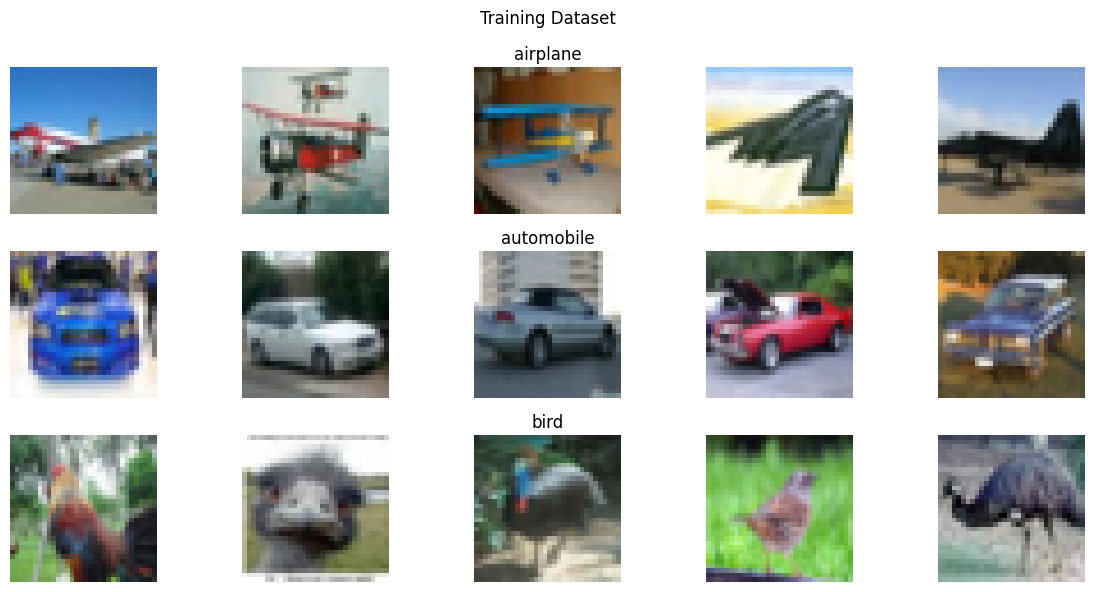

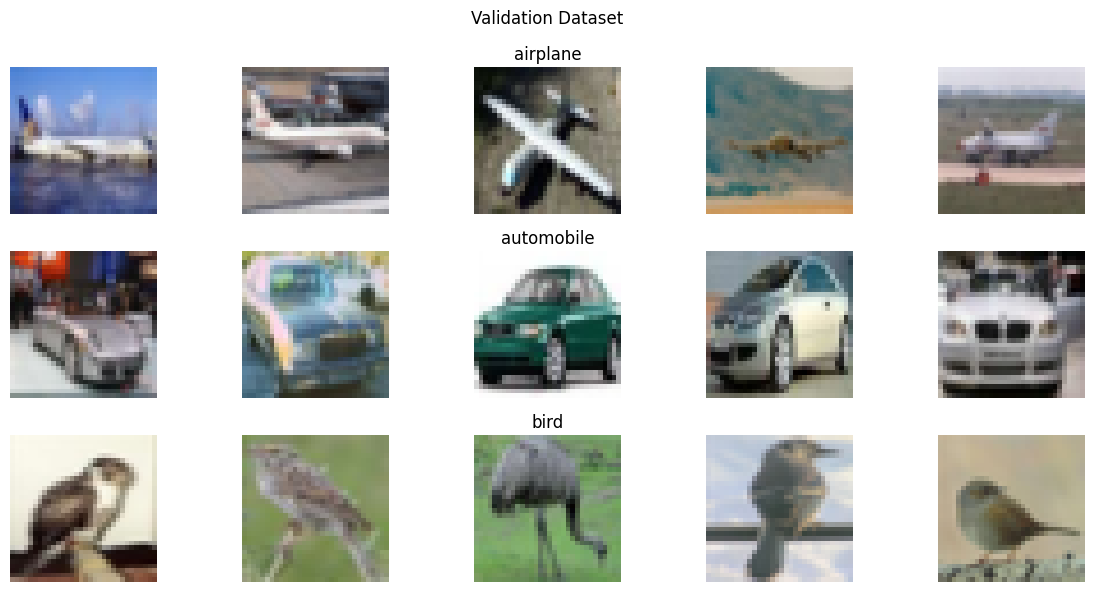

In [ ]:
# Defining the classes to include (e.g., 0: airplane, 1: automobile, 2: bird)
selected_classes = [0, 1, 2]

# Class names for visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Defining  transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Loading the full CIFAR-10  datasets
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter indices for selected classes for training and testing datasets
train_indices = [i for i, label in enumerate(train_dataset_full.targets) if label in selected_classes]
test_indices = [i for i, label in enumerate(test_dataset_full.targets) if label in selected_classes]

# Extracting  corresponding labels for the filtered training indices
train_labels_selected = [train_dataset_full.targets[i] for i in train_indices]

# Converting the lists into numpy arrays 
train_indices = np.array(train_indices)
train_labels_selected = np.array(train_labels_selected)

# Stratified split of training indices into training and validation sets 
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss.split(train_indices, train_labels_selected):
    train_indices_split = train_indices[train_idx]
    val_indices_split = train_indices[val_idx]

# Custom Dataset class for training and validation sets
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        return img, label

# Creating datasets using the custom Dataset class
train_dataset = CustomCIFAR10Dataset(train_dataset_full, train_indices_split)
val_dataset = CustomCIFAR10Dataset(train_dataset_full, val_indices_split)
test_dataset = CustomCIFAR10Dataset(test_dataset_full, test_indices)

# Creating data loaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to visualize images from the dataset
def visualize_images(dataset, classes, title):
    class_count = {cls: 0 for cls in classes}
    images_per_class = {cls: [] for cls in classes}

    # Collect 5 images per class
    for img, label in dataset:
        if label in classes and class_count[label] < 5:
            images_per_class[label].append(img)
            class_count[label] += 1
        if all(count == 5 for count in class_count.values()):
            break

    # Plot images
    fig, axes = plt.subplots(len(classes), 5, figsize=(12, 6))
    fig.suptitle(title)
    for i, cls in enumerate(classes):
        for j in range(5):
            img = images_per_class[cls][j]
            npimg = img.numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            axes[i, j].axis('off')
            if j == 2:
                axes[i, j].set_title(class_names[cls])
    plt.tight_layout()
    plt.show()

# Visualize 5 images of each class from the training dataset
visualize_images(train_dataset, selected_classes, 'Training Dataset')

# Visualize 5 images of each class from the validation dataset
visualize_images(val_dataset, selected_classes, 'Validation Dataset')


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels=3,       
            out_channels=16,     
            kernel_size=5,       
            stride=1,            
            padding=1            
        )
        # First max-pooling layer
        self.pool1 = nn.MaxPool2d(
            kernel_size=3,        
            stride=2              
        )
        # Second convolutional layer
        self.conv2 = nn.Conv2d(
            in_channels=16,       
            out_channels=32,      
            kernel_size=3,        
            stride=1,             
            padding=0            
        )
        # Second max-pooling layer
        self.pool2 = nn.MaxPool2d(
            kernel_size=3,        
            stride=3              
        )
        # Computing the size of the flattened features
        self.flattened_size = 32 * 4 * 4  
        # First fully connected layer
        self.fc1 = nn.Linear(
            in_features=self.flattened_size,
            out_features=16        # 16 neurons
        )
        # Classification head
        self.fc2 = nn.Linear(
            in_features=16,
            out_features=num_classes  
        )

    def forward(self, x):
        # First convolutional layer + ReLU activation
        x = F.relu(self.conv1(x))
        # First max-pooling layer
        x = self.pool1(x)
        # Second convolutional layer + ReLU activation
        x = F.relu(self.conv2(x))
        # Second max-pooling layer
        x = self.pool2(x)
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        # First fully connected layer + ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer (classification head)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel(num_classes=3)
print(model)

# Test the model with a sample input
sample_input = torch.randn(1, 3, 32, 32)  # Batch size of 1
output = model(sample_input)
print('Output shape:', output.shape)


CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)
Output shape: torch.Size([1, 3])


Validation Epoch 1/15: 100%|██████████| 47/47 [00:00<00:00, 51.67it/s]


Epoch [1/15] Train Loss: 0.8931, Train Acc: 60.41% Val Loss: 0.7104, Val Acc: 69.70%


Validation Epoch 2/15: 100%|██████████| 47/47 [00:00<00:00, 51.34it/s]


Epoch [2/15] Train Loss: 0.6167, Train Acc: 75.12% Val Loss: 0.6337, Val Acc: 74.57%


Validation Epoch 3/15: 100%|██████████| 47/47 [00:00<00:00, 50.89it/s]


Epoch [3/15] Train Loss: 0.5375, Train Acc: 78.58% Val Loss: 0.5159, Val Acc: 79.23%


Validation Epoch 4/15: 100%|██████████| 47/47 [00:00<00:00, 53.13it/s]


Epoch [4/15] Train Loss: 0.4908, Train Acc: 80.51% Val Loss: 0.5033, Val Acc: 79.33%


Validation Epoch 5/15: 100%|██████████| 47/47 [00:01<00:00, 36.70it/s]


Epoch [5/15] Train Loss: 0.4742, Train Acc: 81.17% Val Loss: 0.4701, Val Acc: 81.30%


Validation Epoch 6/15: 100%|██████████| 47/47 [00:00<00:00, 50.03it/s]


Epoch [6/15] Train Loss: 0.4392, Train Acc: 82.80% Val Loss: 0.4703, Val Acc: 81.77%


Validation Epoch 7/15: 100%|██████████| 47/47 [00:01<00:00, 40.77it/s]


Epoch [7/15] Train Loss: 0.4239, Train Acc: 83.47% Val Loss: 0.4205, Val Acc: 83.23%


Validation Epoch 8/15: 100%|██████████| 47/47 [00:00<00:00, 49.09it/s]


Epoch [8/15] Train Loss: 0.4036, Train Acc: 84.12% Val Loss: 0.4253, Val Acc: 83.43%


Validation Epoch 9/15: 100%|██████████| 47/47 [00:00<00:00, 52.13it/s]


Epoch [9/15] Train Loss: 0.3831, Train Acc: 85.02% Val Loss: 0.4022, Val Acc: 84.37%


Validation Epoch 10/15: 100%|██████████| 47/47 [00:00<00:00, 56.08it/s]


Epoch [10/15] Train Loss: 0.3702, Train Acc: 85.56% Val Loss: 0.3944, Val Acc: 84.87%


Validation Epoch 11/15: 100%|██████████| 47/47 [00:01<00:00, 37.85it/s]


Epoch [11/15] Train Loss: 0.3652, Train Acc: 85.83% Val Loss: 0.4251, Val Acc: 83.07%


Validation Epoch 12/15: 100%|██████████| 47/47 [00:01<00:00, 40.14it/s]


Epoch [12/15] Train Loss: 0.3545, Train Acc: 86.29% Val Loss: 0.3640, Val Acc: 85.97%


Validation Epoch 13/15: 100%|██████████| 47/47 [00:01<00:00, 40.52it/s]


Epoch [13/15] Train Loss: 0.3383, Train Acc: 86.83% Val Loss: 0.3674, Val Acc: 85.83%


Validation Epoch 14/15: 100%|██████████| 47/47 [00:00<00:00, 50.40it/s]


Epoch [14/15] Train Loss: 0.3310, Train Acc: 87.33% Val Loss: 0.3663, Val Acc: 85.63%


Validation Epoch 15/15: 100%|██████████| 47/47 [00:00<00:00, 51.49it/s]


Epoch [15/15] Train Loss: 0.3232, Train Acc: 87.62% Val Loss: 0.3631, Val Acc: 86.13%


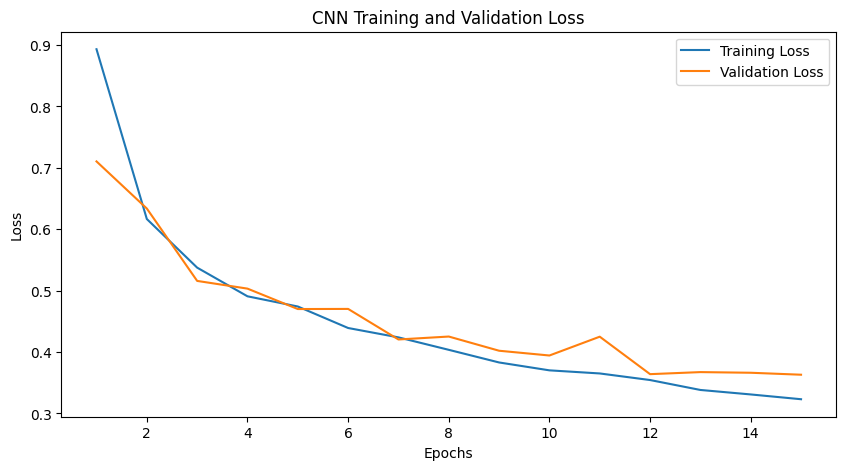

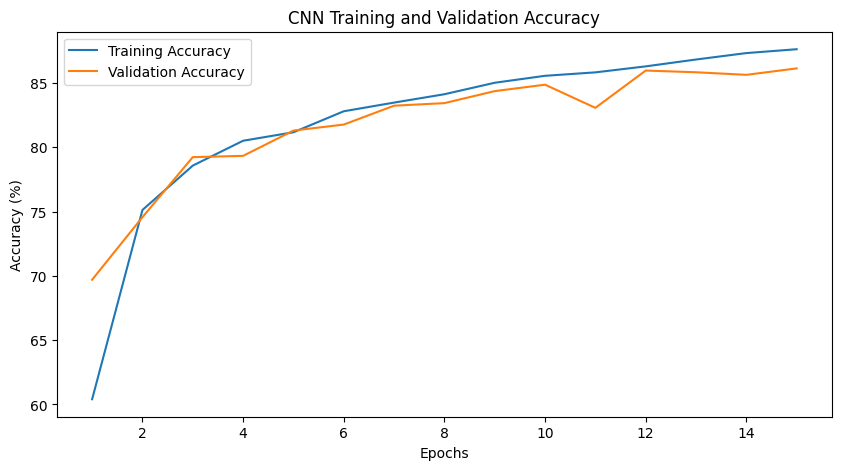

In [ ]:
# Instantiating the model
cnn_model = CNNModel(num_classes=3).to(device)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(cnn_model.parameters(), lr=0.001)

num_epochs = 15

# Listing to store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    cnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * images.size(0)
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    cnn_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn_model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

    # Saving the model checkpoint
    if(epoch==14):
        torch.save(cnn_model.state_dict(), f'cnn_model_epoch_{epoch+1}.pth')

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


C:\Users\amank\AppData\Local\Temp\ipykernel_21876\1767828890.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load('cnn_model_epoch_15.pth

Test Accuracy: 86.37%
Test F1-Score: 0.8628

Classification Report on Test Data:
              precision    recall  f1-score   support

    airplane       0.84      0.82      0.83      1000
  automobile       0.87      0.94      0.91      1000
        bird       0.88      0.82      0.85      1000

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



Evaluating: 100%|██████████| 47/47 [00:00<00:00, 47.32it/s]


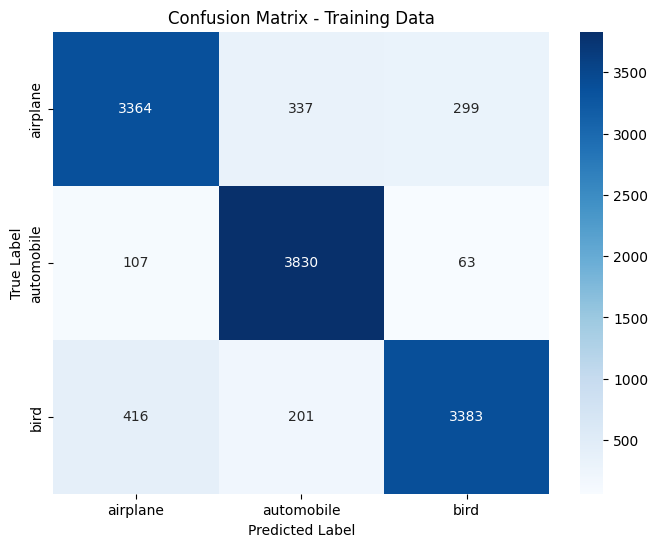

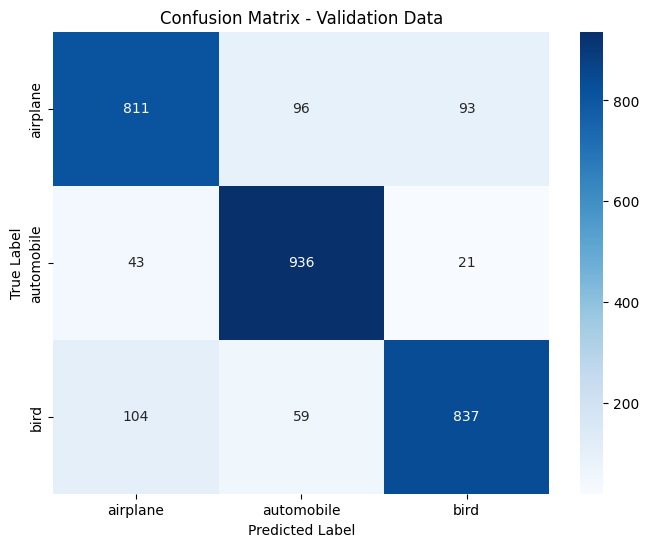

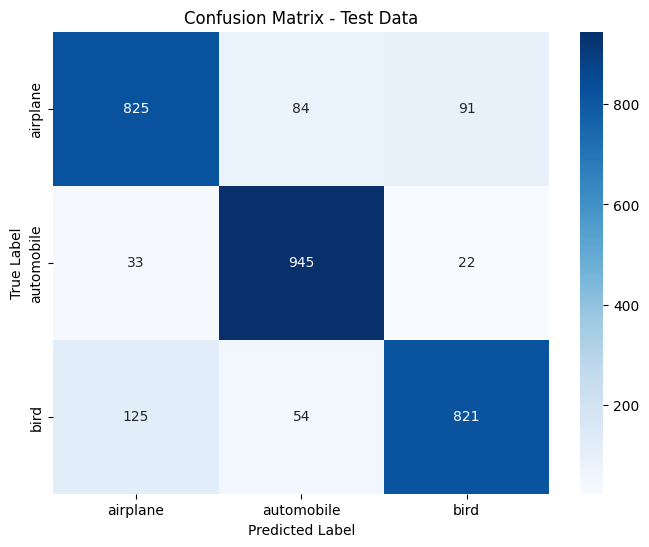

In [ ]:
# Loading the best model 
cnn_model = CNNModel(num_classes=3)
cnn_model.load_state_dict(torch.load('cnn_model_epoch_15.pth'))
cnn_model.to(device)
cnn_model.eval()

# Function to evaluate the model and get predictions and labels
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate on test dataset
test_preds, test_labels = evaluate_model(cnn_model, test_loader)

# Calculate accuracy and F1-score on test dataset
test_accuracy = np.mean(test_preds == test_labels) * 100
test_f1_score = f1_score(test_labels, test_preds, average='macro')

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1-Score: {test_f1_score:.4f}")

# Classification report
print("\nClassification Report on Test Data:")
print(classification_report(test_labels, test_preds, target_names=[class_names[i] for i in selected_classes]))

# Plot confusion matrix for test dataset
def plot_confusion_matrix(labels, preds, classes, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrices for train, val, and test datasets
# First, get predictions and labels for each dataset
train_preds, train_labels = evaluate_model(cnn_model, train_loader)
val_preds, val_labels = evaluate_model(cnn_model, val_loader)

# Plot confusion matrices
plot_confusion_matrix(train_labels, train_preds, [class_names[i] for i in selected_classes], 'Training Data')
plot_confusion_matrix(val_labels, val_preds, [class_names[i] for i in selected_classes], 'Validation Data')
plot_confusion_matrix(test_labels, test_preds, [class_names[i] for i in selected_classes], 'Test Data')

# # Plotting training and validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
# plt.title('CNN Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plotting training and validation accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
# plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
# plt.title('CNN Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.show()


In [ ]:
# Defining the MLP Model
class MLPModel(nn.Module):
    def __init__(self, num_classes=3):
        super(MLPModel, self).__init__()
        # Flattened image size: 3 (channels) * 32 (height) * 32 (width) = 3072
        self.input_size = 3 * 32 * 32
        # First fully connected layer
        self.fc1 = nn.Linear(self.input_size, 64)
        # ReLU activation
        self.relu = nn.ReLU()
        # Classification head
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)
        # Passing through the first fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        # Passing through the classification head
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device
mlp_model = MLPModel(num_classes=3).to(device)
print(mlp_model)


MLPModel(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


MLP Validation Epoch 1/15: 100%|██████████| 47/47 [00:00<00:00, 79.43it/s]


Epoch [1/15] Train Loss: 0.8899, Train Acc: 60.10% Val Loss: 0.7979, Val Acc: 67.80%


MLP Validation Epoch 2/15: 100%|██████████| 47/47 [00:00<00:00, 77.64it/s]


Epoch [2/15] Train Loss: 0.7715, Train Acc: 68.03% Val Loss: 0.7943, Val Acc: 67.07%


MLP Validation Epoch 3/15: 100%|██████████| 47/47 [00:00<00:00, 82.10it/s]


Epoch [3/15] Train Loss: 0.7395, Train Acc: 69.30% Val Loss: 0.8009, Val Acc: 67.83%


MLP Validation Epoch 4/15: 100%|██████████| 47/47 [00:00<00:00, 91.68it/s] 


Epoch [4/15] Train Loss: 0.6975, Train Acc: 71.62% Val Loss: 0.7004, Val Acc: 72.00%


MLP Validation Epoch 5/15: 100%|██████████| 47/47 [00:00<00:00, 98.86it/s] 


Epoch [5/15] Train Loss: 0.6840, Train Acc: 71.77% Val Loss: 0.7054, Val Acc: 71.73%


MLP Validation Epoch 6/15: 100%|██████████| 47/47 [00:00<00:00, 98.38it/s]


Epoch [6/15] Train Loss: 0.6484, Train Acc: 73.72% Val Loss: 0.6628, Val Acc: 74.43%


MLP Validation Epoch 7/15: 100%|██████████| 47/47 [00:00<00:00, 99.00it/s] 


Epoch [7/15] Train Loss: 0.6405, Train Acc: 73.87% Val Loss: 0.6783, Val Acc: 73.57%


MLP Validation Epoch 8/15: 100%|██████████| 47/47 [00:00<00:00, 72.61it/s]


Epoch [8/15] Train Loss: 0.6193, Train Acc: 74.94% Val Loss: 0.6582, Val Acc: 73.57%


MLP Validation Epoch 9/15: 100%|██████████| 47/47 [00:00<00:00, 96.83it/s] 


Epoch [9/15] Train Loss: 0.6118, Train Acc: 75.19% Val Loss: 0.6479, Val Acc: 74.07%


MLP Validation Epoch 10/15: 100%|██████████| 47/47 [00:00<00:00, 100.05it/s]


Epoch [10/15] Train Loss: 0.6024, Train Acc: 75.22% Val Loss: 0.6608, Val Acc: 72.47%


MLP Validation Epoch 11/15: 100%|██████████| 47/47 [00:00<00:00, 101.56it/s]


Epoch [11/15] Train Loss: 0.5863, Train Acc: 76.44% Val Loss: 0.6305, Val Acc: 74.70%


MLP Validation Epoch 12/15: 100%|██████████| 47/47 [00:00<00:00, 99.42it/s] 


Epoch [12/15] Train Loss: 0.5747, Train Acc: 77.08% Val Loss: 0.6719, Val Acc: 71.53%


MLP Validation Epoch 13/15: 100%|██████████| 47/47 [00:00<00:00, 103.12it/s]


Epoch [13/15] Train Loss: 0.5667, Train Acc: 77.47% Val Loss: 0.6935, Val Acc: 71.70%


MLP Validation Epoch 14/15: 100%|██████████| 47/47 [00:00<00:00, 106.62it/s]


Epoch [14/15] Train Loss: 0.5536, Train Acc: 77.67% Val Loss: 0.6096, Val Acc: 76.23%


MLP Validation Epoch 15/15: 100%|██████████| 47/47 [00:00<00:00, 98.80it/s] 


Epoch [15/15] Train Loss: 0.5492, Train Acc: 77.89% Val Loss: 0.6171, Val Acc: 75.67%


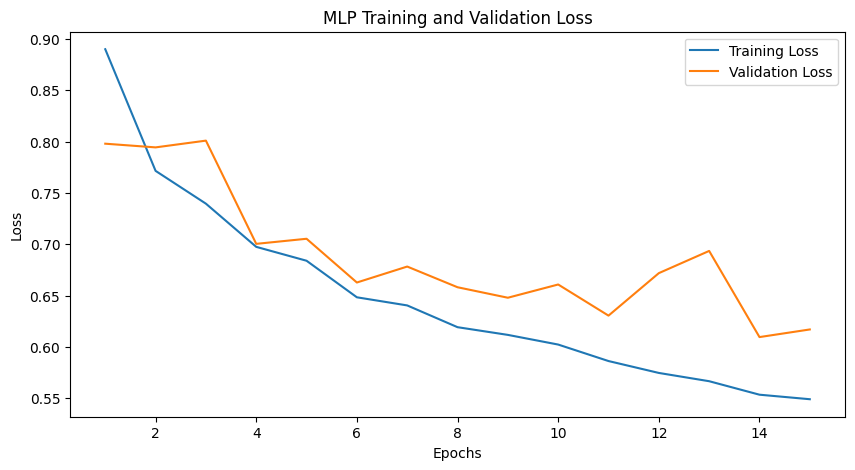

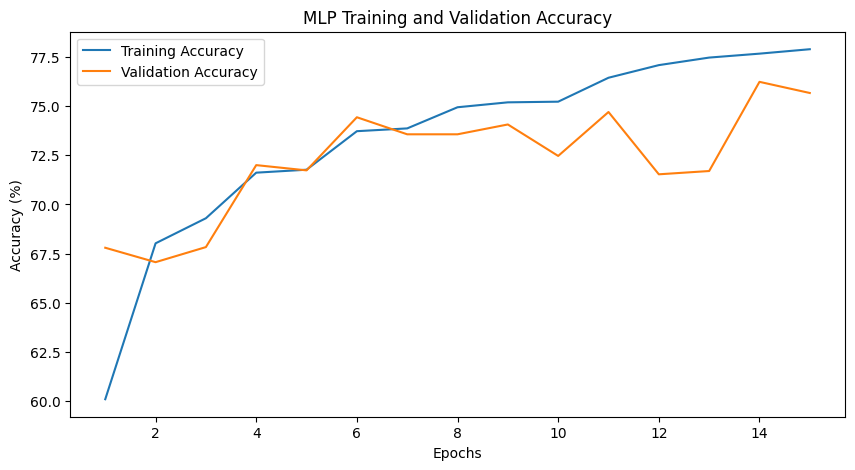

In [ ]:
# Defining the loss function and optimizer
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = Adam(mlp_model.parameters(), lr=0.001)
mlp_num_epochs = 15

# Listing to store loss and accuracy for plotting
mlp_train_losses = []
mlp_val_losses = []
mlp_train_accuracies = []
mlp_val_accuracies = []

for epoch in range(mlp_num_epochs):
    # Training phase
    mlp_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"MLP Training Epoch {epoch+1}/{mlp_num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = mlp_model(images)
        loss = mlp_criterion(outputs, labels)

        # Backward pass and optimization
        mlp_optimizer.zero_grad()
        loss.backward()
        mlp_optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * images.size(0)
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    mlp_train_losses.append(epoch_loss)
    mlp_train_accuracies.append(epoch_acc)

    # Validation phase
    mlp_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"MLP Validation Epoch {epoch+1}/{mlp_num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = mlp_model(images)
            loss = mlp_criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    mlp_val_losses.append(val_epoch_loss)
    mlp_val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{mlp_num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

    # Saving the model 
    if(epoch==14):
        torch.save(mlp_model.state_dict(), f'mlp_model_epoch_{epoch+1}.pth')

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, mlp_num_epochs+1), mlp_train_losses, label='Training Loss')
plt.plot(range(1, mlp_num_epochs+1), mlp_val_losses, label='Validation Loss')
plt.title('MLP Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, mlp_num_epochs+1), mlp_train_accuracies, label='Training Accuracy')
plt.plot(range(1, mlp_num_epochs+1), mlp_val_accuracies, label='Validation Accuracy')
plt.title('MLP Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()




C:\Users\amank\AppData\Local\Temp\ipykernel_21876\3721435162.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load('mlp_model_epoch_15.pth

MLP Model Test Accuracy: 76.50%
MLP Model Test F1-Score: 0.7652

MLP Model Classification Report on Test Data:
              precision    recall  f1-score   support

    airplane       0.73      0.71      0.72      1000
  automobile       0.84      0.79      0.81      1000
        bird       0.73      0.80      0.76      1000

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



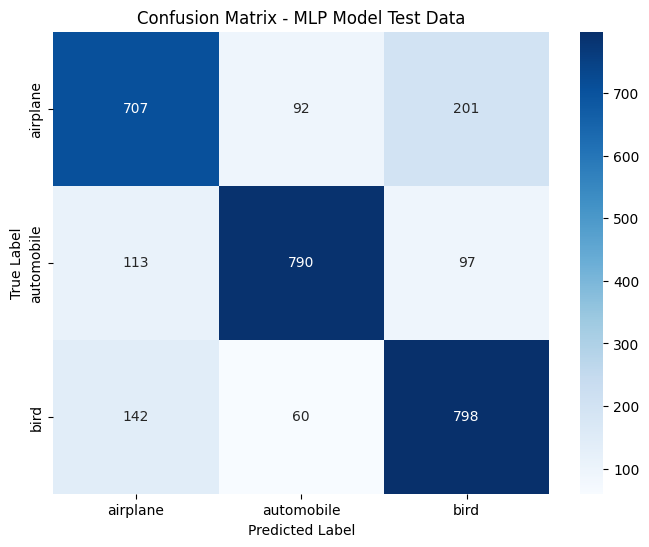

In [ ]:
# Loading the trained MLP model
mlp_model = MLPModel(num_classes=3)
mlp_model.load_state_dict(torch.load('mlp_model_epoch_15.pth'))
mlp_model.to(device)
mlp_model.eval()

# Evaluating the MLP model on the test dataset
mlp_test_preds, mlp_test_labels = evaluate_model(mlp_model, test_loader)

# Calculating accuracy and F1-score for the MLP model
mlp_test_accuracy = np.mean(mlp_test_preds == mlp_test_labels) * 100
mlp_test_f1_score = f1_score(mlp_test_labels, mlp_test_preds, average='macro')

print(f"MLP Model Test Accuracy: {mlp_test_accuracy:.2f}%")
print(f"MLP Model Test F1-Score: {mlp_test_f1_score:.4f}")

# Classification report for the MLP model
print("\nMLP Model Classification Report on Test Data:")
print(classification_report(mlp_test_labels, mlp_test_preds, target_names=[class_names[i] for i in selected_classes]))

# Plot confusion matrix for the MLP model
def plot_confusion_matrix(labels, preds, classes, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(mlp_test_labels, mlp_test_preds, [class_names[i] for i in selected_classes], 'MLP Model Test Data')
